### This (auxiliary) notebook shows CelebA/LSUN classifier evaluation according to conventional performance metrics

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from latentspace.datasets import *
from latentspace.ml_util import *
from latentspace.cnn import *
from latentspace.adversarial_generation import *
from latentspace.evaluation_util import EvaluationUtil

### Load dataset

* Comment/uncomment to switch between CelebA and LSUN

In [3]:
#dataset_info = DatasetInfo.CelebA128Gender
#dataset_info = DatasetInfo.LSUN128
dataset_info = DatasetInfo.ImageNetAnimals

if dataset_info == DatasetInfo.CelebA128Gender:
    trainer_name = "celeba-128"
    ds = CelebAData(20)
    no_classes = 2
elif dataset_info == DatasetInfo.LSUN128:
    trainer_name = "lsun-128"
    ds = LSUNData()
    no_classes = 2
elif dataset_info == DatasetInfo.ImageNetAnimals:
    trainer_name = "animals-128"
    ds = ImageNetAnimalsData()
    no_classes = 3
else:
    raise RuntimeError()
class_weights = [1 / no_classes] * no_classes

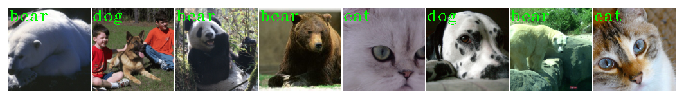

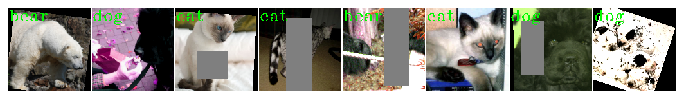

In [4]:
# get some random training images (without data augmentation, with conventional data augmentation)
for loader in [ds.get_unaugmented_train_loader(batch_size=8), ds.get_train_loader(batch_size=8)]:
    images, labels = next(iter(loader))
    Util.imshow_tensors(images, captions=ds.prediction_indices_to_printed_classes(labels), nrow=8)

### Load classifiers

In [4]:
#filenames = "oneepoch plain conventional robust both".split(" ")
filenames = "plain conventional robust".split(" ")
#unit_types = [0, 1, 2]
unit_types = [0]
def load_classifier(filename: str, unit_type: int):   
    weights_filename = f"classifiers_architecture{unit_type}/{filename}_{dataset_info.name}.bin"
    c = Trainer(trainer_name, ds.get_train_loader, ds.get_test_loader, unit_type)
    c.restore_params_from_disk(weights_filename)
    return c
classifiers = [load_classifier(filename, unit_type) for unit_type in unit_types for filename in filenames]

animals-128 classifier: 302187 trainable parameters
animals-128 classifier: 302187 trainable parameters
animals-128 classifier: 302187 trainable parameters


### A few predictions

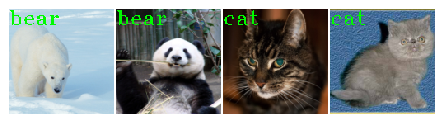

Predicted 0: ['bear', 'bear', 'cat', 'cat']
Predicted 1: ['bear', 'bear', 'cat', 'cat']
Predicted 2: ['bear', 'bear', 'cat', 'cat']


In [5]:
EvaluationUtil.show_some_predictions(classifiers, ds)

### Classifier evaluation: clean accuracy and noise corruption accuracy (on the validation set)

In [6]:
EvaluationUtil.evaluate_accuracy(classifiers, ds, 100)

Accuracy of classifier 0 on 100 validation images (noise 0.0):  72.00%
Accuracy of classifier 0 on 100 validation images (noise 0.8):  51.00%
Accuracy of classifier 1 on 100 validation images (noise 0.0):  73.00%
Accuracy of classifier 1 on 100 validation images (noise 0.8):  43.00%
Accuracy of classifier 2 on 100 validation images (noise 0.0):  71.00%
Accuracy of classifier 2 on 100 validation images (noise 0.8):  72.00%


### Evaluation: adversarial frequency and severity in the original space (on the validation set)

* Adversarial frequency = accuracy on worst-case perturbed images within allowed bounds
* Adversarial severity = expected size of a minimum adversarial perturbation

In [ ]:
EvaluationUtil.evaluate_conventional_robustness(classifiers, ds, 4, l_2_bounds=[0.0025, 0.005], l_inf_bounds=[0.005, 0.01])

In [ ]:
EvaluationUtil.evaluate_conventional_adversarial_severity(classifiers, ds, 4, OTHER_L2_UPPER_BOUND, OTHER_LINF_UPPER_BOUND)

### Evaluation: optimize class activations

* Robust classifiers should be capable of limited image generation by maximizing their class activations
* Here, this is visible only on CelebA

In [ ]:
generate = lambda args: EvaluationUtil.generate_images_with_classifier(classifiers, ds, no_classes, *args)
if dataset_info == DatasetInfo.CelebA128Gender:
    args = [0.05, "l_inf", 0.3]
else:
    args = [0.1, "scaled_l_2", 0.6]
generate(args)